# EDA – Udemy Course Dataset (Entrega 3)

Objetivos:
* Analisar a base original
* Produzir um arquivo limpo
* Arquivo deve estar pronto para a próxima etapa do projeto (tratamento → técnica → PoC).

# 1 - Configurações do ambiente e carregamento do dataset

In [48]:
from pathlib import Path

PROJECT_ROOT = Path(".").resolve()

DATA_RAW     = PROJECT_ROOT / "data" / "raw"
DATA_INT     = PROJECT_ROOT / "data" / "interim"
DATA_PROC    = PROJECT_ROOT / "data" / "processed"
MODELS_DIR   = PROJECT_ROOT / "models"
REPORTS_DIR  = PROJECT_ROOT / "reports"

for d in [DATA_RAW, DATA_INT, DATA_PROC, MODELS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

raw_path = raw_path = PROJECT_ROOT / "udemy_course_data.csv"

df = pd.read_csv(raw_path)
print("Dimensões:", df.shape)
df.head()



Dimensões: (3683, 18)


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,profit,published_date,published_time,year,month,day
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hours,2017-01-18T20:58:58Z,Business Finance,429400,2017-01-18,20:58:58Z,2017,1,18
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39 hours,2017-03-09T16:34:20Z,Business Finance,209400,2017-03-09,16:34:20Z,2017,3,9
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5 hours,2016-12-19T19:26:30Z,Business Finance,97830,2016-12-19,19:26:30Z,2016,12,19
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3 hours,2017-05-30T20:07:24Z,Business Finance,232845,2017-05-30,20:07:24Z,2017,5,30
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2 hours,2016-12-13T14:57:18Z,Business Finance,255200,2016-12-13,14:57:18Z,2016,12,13


# 2 - Estrutura: colunas, tipos e amostra

In [49]:
print("Colunas:\n", list(df.columns))
print("\nTipos de dados:\n", df.dtypes)
print(df.sample(10))


Colunas:
 ['course_id', 'course_title', 'url', 'is_paid', 'price', 'num_subscribers', 'num_reviews', 'num_lectures', 'level', 'content_duration', 'published_timestamp', 'subject', 'profit', 'published_date', 'published_time', 'year', 'month', 'day']

Tipos de dados:
 course_id               int64
course_title           object
url                    object
is_paid                  bool
price                   int64
num_subscribers         int64
num_reviews             int64
num_lectures            int64
level                  object
content_duration       object
published_timestamp    object
subject                object
profit                  int64
published_date         object
published_time         object
year                    int64
month                   int64
day                     int64
dtype: object
      course_id                                       course_title                                                url  \
465     1084454                  CFA Level 2- Quantitativ

# 3 - Nulos e duplicados

In [50]:
nulls = df.isnull().sum().sort_values(ascending=False)
print("Nulos por coluna (ordem desc):")
print(nulls)

dup_id = df.duplicated(subset=["course_id"]).sum() if "course_id" in df.columns else None
dup_title = df.duplicated(subset=["course_title"]).sum() if "course_title" in df.columns else None
print({"duplicados_por_course_id": dup_id, "duplicados_por_course_title": dup_title})


Nulos por coluna (ordem desc):
published_time         1
course_id              0
course_title           0
url                    0
price                  0
is_paid                0
num_reviews            0
num_lectures           0
level                  0
num_subscribers        0
content_duration       0
published_timestamp    0
profit                 0
subject                0
published_date         0
year                   0
month                  0
day                    0
dtype: int64
{'duplicados_por_course_id': np.int64(6), 'duplicados_por_course_title': np.int64(15)}


# 4 - Engenharia leve: duração (horas), pago/gratuito, datas

In [51]:
def parse_hours(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if "hour" in s:
        try:
            return float(s.split()[0])
        except:
            return np.nan
    if "min" in s:
        try:
            return float(s.split()[0]) / 60.0
        except:
            return np.nan
    try:
        return float(s)
    except:
        return np.nan

if "content_duration" in df.columns:
    df["content_duration_hours"] = df["content_duration"].apply(parse_hours)

# rótulo de pago/gratuito
if "is_paid" in df.columns:
    tmp = df["is_paid"].astype(str).str.lower()
    mapper = {"true": True, "false": False, "paid": True, "free": False}
    paid_bool = tmp.map(lambda v: mapper.get(v, np.nan))
    if paid_bool.isna().mean() > 0.4 and "price" in df.columns:
        paid_bool = pd.to_numeric(df["price"], errors="coerce").fillna(0) > 0
    df["paid_label"] = np.where(paid_bool, "Pago", "Gratuito")
elif "price" in df.columns:
    df["paid_label"] = np.where(pd.to_numeric(df["price"], errors="coerce").fillna(0) > 0, "Pago", "Gratuito")

# datas
if "published_timestamp" in df.columns:
    df["published_dt"] = pd.to_datetime(df["published_timestamp"], errors="coerce")
elif "published_date" in df.columns:
    df["published_dt"] = pd.to_datetime(df["published_date"] + " " + df.get("published_time", ""), errors="coerce")
else:
    df["published_dt"] = pd.NaT

df["year"] = df["published_dt"].dt.year
df["month"] = df["published_dt"].dt.month
df["day"] = df["published_dt"].dt.day

print(df.head())


   course_id                                       course_title                                                url  \
0    1070968                 Ultimate Investment Banking Course  https://www.udemy.com/ultimate-investment-bank...   
1    1113822  Complete GST Course & Certification - Grow You...      https://www.udemy.com/goods-and-services-tax/   
2    1006314  Financial Modeling for Business Analysts and C...  https://www.udemy.com/financial-modeling-for-b...   
3    1210588  Beginner to Pro - Financial Analysis in Excel ...  https://www.udemy.com/complete-excel-finance-c...   
4    1011058       How To Maximize Your Profits Trading Options  https://www.udemy.com/how-to-maximize-your-pro...   

   is_paid  price  num_subscribers  num_reviews  num_lectures               level content_duration  \
0     True    200             2147           23            51          All Levels        1.5 hours   
1     True     75             2792          923           274          All Levels      

# 5 - Resumo estatístico de numéricos

In [52]:
num_cols = [c for c in ["price","num_subscribers","num_reviews","num_lectures","profit","content_duration_hours","year","month","day"] if c in df.columns]
print(df[num_cols].describe().T)


                         count           mean           std     min     25%      50%       75%         max
price                   3683.0      65.992398  6.098559e+01     0.0    20.0     45.0      95.0       200.0
num_subscribers         3683.0    3193.371165  9.498231e+03     0.0   110.0    911.0    2537.5    268923.0
num_reviews             3683.0     156.448004  9.350782e+02     0.0     4.0     18.0      67.0     27445.0
num_lectures            3683.0      40.062178  5.036679e+01     0.0    15.0     25.0      45.0       779.0
profit                  3683.0  240288.459137  1.000760e+06     0.0  1567.5  23050.0  118260.0  24316800.0
content_duration_hours  3678.0       4.094517  6.053840e+00     0.0     1.0      2.0       4.5        78.5
year                    3682.0    2015.432917  1.185800e+00  2011.0  2015.0   2016.0    2016.0      2017.0
month                   3682.0       6.164041  3.378702e+00     1.0     3.0      6.0       9.0        12.0
day                     3682.0      1

# 6 - Distribuição por assunto (subject)

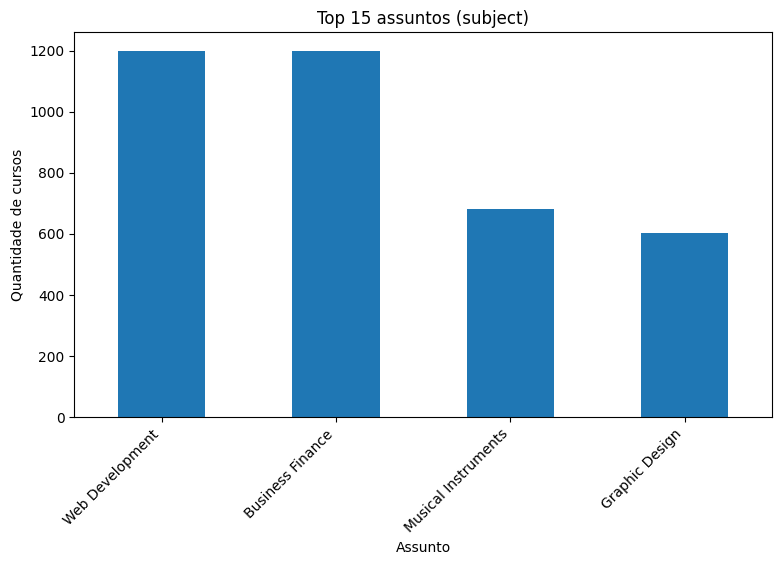

In [53]:
if "subject" in df.columns:
    plt.figure(figsize=(9,5))
    df["subject"].value_counts().head(15).plot(kind="bar")
    plt.title("Top 15 assuntos (subject)")
    plt.xlabel("Assunto")
    plt.ylabel("Quantidade de cursos")
    plt.xticks(rotation=45, ha="right")
    plt.show()


# 7 - Distribuição por nível (level)

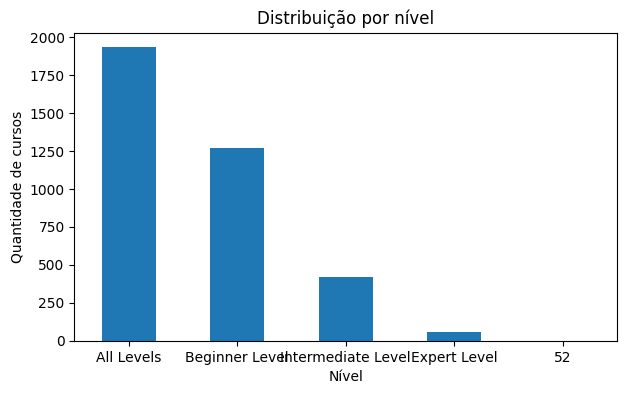

In [54]:
if "level" in df.columns:
    plt.figure(figsize=(7,4))
    df["level"].fillna("Unknown").value_counts().plot(kind="bar")
    plt.title("Distribuição por nível")
    plt.xlabel("Nível")
    plt.ylabel("Quantidade de cursos")
    plt.xticks(rotation=0)
    plt.show()


# 8 - Pagos vs Gratuitos

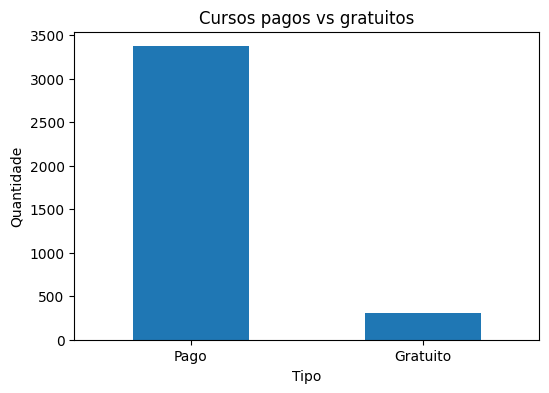

In [55]:
if "paid_label" in df.columns:
    plt.figure(figsize=(6,4))
    df["paid_label"].value_counts().plot(kind="bar")
    plt.title("Cursos pagos vs gratuitos")
    plt.xlabel("Tipo")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)
    plt.show()


# 9 - Distribuição de preço

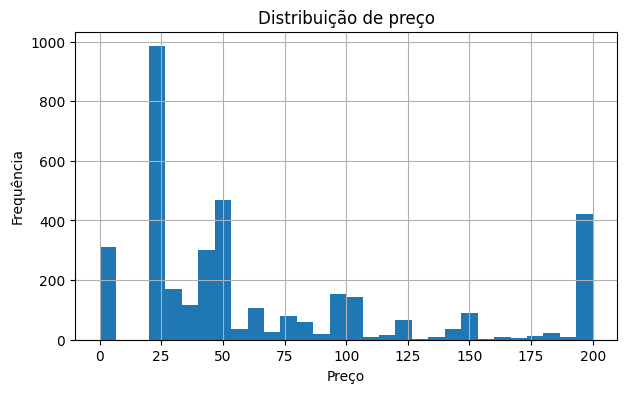

In [56]:
if "price" in df.columns:
    plt.figure(figsize=(7,4))
    pd.to_numeric(df["price"], errors="coerce").dropna().hist(bins=30)
    plt.title("Distribuição de preço")
    plt.xlabel("Preço")
    plt.ylabel("Frequência")
    plt.show()


# 10 - Distribuição de inscritos (log1p)

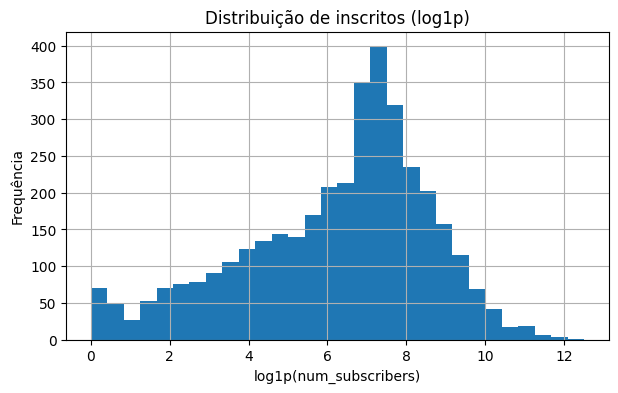

In [57]:
if "num_subscribers" in df.columns:
    plt.figure(figsize=(7,4))
    np.log1p(pd.to_numeric(df["num_subscribers"], errors="coerce")).dropna().hist(bins=30)
    plt.title("Distribuição de inscritos (log1p)")
    plt.xlabel("log1p(num_subscribers)")
    plt.ylabel("Frequência")
    plt.show()


# 11 - Distribuição da duração (horas)

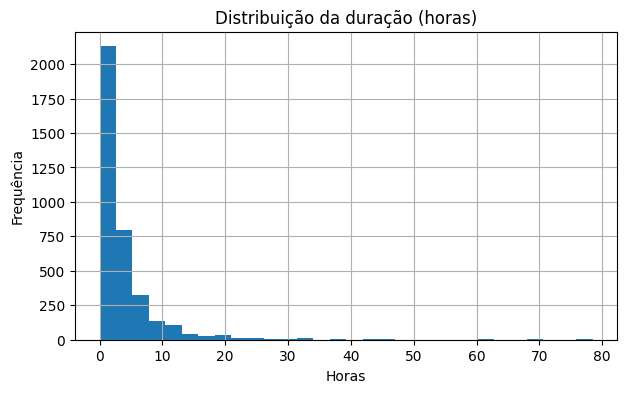

In [58]:
if "content_duration_hours" in df.columns:
    plt.figure(figsize=(7,4))
    pd.to_numeric(df["content_duration_hours"], errors="coerce").dropna().hist(bins=30)
    plt.title("Distribuição da duração (horas)")
    plt.xlabel("Horas")
    plt.ylabel("Frequência")
    plt.show()


# 12 - Top 10 por número de inscritos

In [59]:
cols_show = [c for c in ["course_id","course_title","subject","level","price","num_subscribers"] if c in df.columns]
if "num_subscribers" in df.columns:
    top10 = df.sort_values("num_subscribers", ascending=False)[cols_show].head()
    print(top10)


      course_id                                       course_title          subject           level  price  \
2832      41295               Learn HTML5 Programming From Scratch  Web Development      All Levels      0   
3037      59014                     Coding for Entrepreneurs Basic  Web Development  Beginner Level      0   
3235     625204                         The Web Developer Bootcamp  Web Development      All Levels    200   
2788     173548  Build Your First Website in 1 Week with HTML5 ...  Web Development  Beginner Level      0   
3237     764164              The Complete Web Developer Course 2.0  Web Development      All Levels    200   

      num_subscribers  
2832           268923  
3037           161029  
3235           121584  
2788           120291  
3237           114512  


# 13 - Correlação entre variáveis numéricas

In [60]:
if len(num_cols) > 0:
    corr = df[num_cols].corr(numeric_only=True)
    print(corr)


                           price  num_subscribers  num_reviews  num_lectures    profit  content_duration_hours  \
price                   1.000000         0.051028     0.113319      0.330505  0.346699                0.293450   
num_subscribers         0.051028         1.000000     0.649649      0.157945  0.557213                0.161839   
num_reviews             0.113319         0.649649     1.000000      0.242933  0.769654                0.228889   
num_lectures            0.330505         0.157945     0.242933      1.000000  0.321901                0.801647   
profit                  0.346699         0.557213     0.769654      0.321901  1.000000                0.296736   
content_duration_hours  0.293450         0.161839     0.228889      0.801647  0.296736                1.000000   
year                    0.131990        -0.184796    -0.053501     -0.026196 -0.059276               -0.058752   
month                   0.038413         0.015258     0.006862      0.031839  0.035095  

# 14 - Limpeza e exportação do dataset

In [61]:
# === Limpeza final do dataset ===

clean = df.copy()

# Remoção de duplicatas
if "course_id" in clean.columns:
    clean = clean.drop_duplicates(subset=["course_id"])
if "course_title" in clean.columns:
    clean = clean.drop_duplicates(subset=["course_title"])

# Conversões numéricas
for col in ["price","num_subscribers","num_reviews","num_lectures",
            "profit","content_duration_hours","year","month","day"]:
    if col in clean.columns:
        clean[col] = pd.to_numeric(clean[col], errors="coerce")

# Normalização das categorias
for col in ["level","subject"]:
    if col in clean.columns:
        clean[col + "_norm"] = clean[col].astype(str).str.strip().str.lower()

# === Salvar arquivo no diretório desejado ===
CUSTOM_SAVE_PATH = Path("/Users/iloop/Desktop/notebooks") / "udemy_courses_clean.csv"

clean.to_csv(CUSTOM_SAVE_PATH, index=False)

print("Arquivo limpo gerado em:", CUSTOM_SAVE_PATH)
clean.head()


Arquivo limpo gerado em: /Users/iloop/Desktop/notebooks/udemy_courses_clean.csv


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,profit,published_date,published_time,year,month,day,content_duration_hours,paid_label,published_dt,level_norm,subject_norm
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hours,2017-01-18T20:58:58Z,Business Finance,429400,2017-01-18,20:58:58Z,2017.0,1.0,18.0,1.5,Pago,2017-01-18 20:58:58+00:00,all levels,business finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39 hours,2017-03-09T16:34:20Z,Business Finance,209400,2017-03-09,16:34:20Z,2017.0,3.0,9.0,39.0,Pago,2017-03-09 16:34:20+00:00,all levels,business finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5 hours,2016-12-19T19:26:30Z,Business Finance,97830,2016-12-19,19:26:30Z,2016.0,12.0,19.0,2.5,Pago,2016-12-19 19:26:30+00:00,intermediate level,business finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3 hours,2017-05-30T20:07:24Z,Business Finance,232845,2017-05-30,20:07:24Z,2017.0,5.0,30.0,3.0,Pago,2017-05-30 20:07:24+00:00,all levels,business finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2 hours,2016-12-13T14:57:18Z,Business Finance,255200,2016-12-13,14:57:18Z,2016.0,12.0,13.0,2.0,Pago,2016-12-13 14:57:18+00:00,intermediate level,business finance


# 15 - Resumo dos achados

In [62]:
summary = {
    "total_cursos": len(clean),
    "qtd_subjects": clean["subject"].nunique() if "subject" in clean.columns else None,
    "percent_free": float((clean["is_paid"] == False).mean()*100) if "is_paid" in clean.columns else None,
    "colunas_disponiveis": list(clean.columns)
}
summary

{'total_cursos': 3668,
 'qtd_subjects': 4,
 'percent_free': 8.424209378407852,
 'colunas_disponiveis': ['course_id',
  'course_title',
  'url',
  'is_paid',
  'price',
  'num_subscribers',
  'num_reviews',
  'num_lectures',
  'level',
  'content_duration',
  'published_timestamp',
  'subject',
  'profit',
  'published_date',
  'published_time',
  'year',
  'month',
  'day',
  'content_duration_hours',
  'paid_label',
  'published_dt',
  'level_norm',
  'subject_norm']}